In [122]:
import findspark
findspark.init()
findspark.find()
import pyspark
findspark.find()

'C:\\spark-3.0.1-bin-hadoop2.7'

In [344]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from plotnine import *
import matplotlib.pyplot as plt
import pandas
import numpy as np

In [124]:
spark = SparkSession.builder.appName('cs5488project').getOrCreate()
injury = spark.read.option("delimiter", ",").csv("PlayerTrackData.csv/InjuryRecord.csv",header=True,inferSchema=True)
playlist = spark.read.option("delimiter", ",").csv("PlayerTrackData.csv/PlayList.csv",header=True,inferSchema=True)
#playtrack = spark.read.option("delimiter", ",").csv("PlayerTrackData.csv/PlayerTrackData.csv",header=True,inferSchema=True)

injury.printSchema()
playlist.printSchema()
#playtrack.printSchema()

root
 |-- PlayerKey: integer (nullable = true)
 |-- GameID: string (nullable = true)
 |-- PlayKey: string (nullable = true)
 |-- BodyPart: string (nullable = true)
 |-- Surface: string (nullable = true)
 |-- DM_M1: integer (nullable = true)
 |-- DM_M7: integer (nullable = true)
 |-- DM_M28: integer (nullable = true)
 |-- DM_M42: integer (nullable = true)

root
 |-- PlayerKey: integer (nullable = true)
 |-- GameID: string (nullable = true)
 |-- PlayKey: string (nullable = true)
 |-- RosterPosition: string (nullable = true)
 |-- PlayerDay: integer (nullable = true)
 |-- PlayerGame: integer (nullable = true)
 |-- StadiumType: string (nullable = true)
 |-- FieldType: string (nullable = true)
 |-- Temperature: integer (nullable = true)
 |-- Weather: string (nullable = true)
 |-- PlayType: string (nullable = true)
 |-- PlayerGamePlay: integer (nullable = true)
 |-- Position: string (nullable = true)
 |-- PositionGroup: string (nullable = true)



In [125]:
injury = injury.withColumn("Severity", col("DM_M1") + col("DM_M7") + col("DM_M28") + col("DM_M42"))
injury = injury.withColumn("SevLevel", when(col("Severity") >=3, "H").otherwise("L"))
injury = injury.select("PlayerKey","GameID","PlayKey","BodyPart","Surface","Severity","SevLevel")

In [126]:
# 1, injury count by surface, severity -- a slightly higher rate for severe injury (missed day > 28 (DM_28 / DM_42)) for synthetic surface
severity = injury.groupBy('Severity', 'Surface').count().orderBy(col("Severity").asc(), col('Surface').desc())

In [127]:
severity.show()

+--------+---------+-----+
|Severity|  Surface|count|
+--------+---------+-----+
|       1|Synthetic|   16|
|       1|  Natural|   13|
|       2|Synthetic|   19|
|       2|  Natural|   20|
|       3|Synthetic|    6|
|       3|  Natural|    2|
|       4|Synthetic|   16|
|       4|  Natural|   13|
+--------+---------+-----+



In [369]:
p1 = ggplot(severity.toPandas(), aes(x='Severity', y='count')) + \
    geom_line(aes(fill='Surface', color='Surface'), size=2) +\
    labs(x="Severity", y='Injury Count') + \
    scale_y_continuous(breaks=np.arange(0, 25, 5))

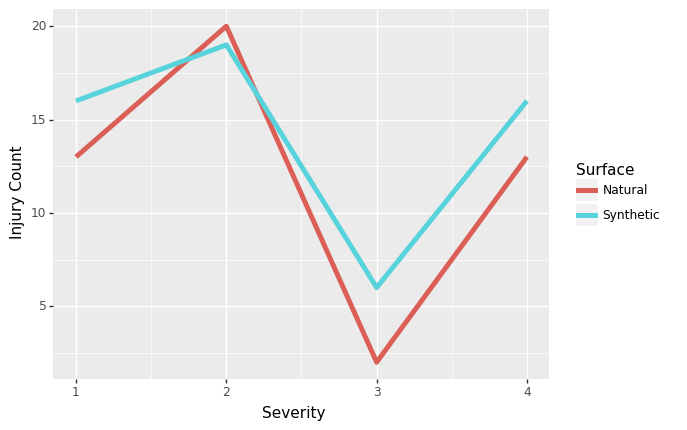

<ggplot: (184188347528)>

In [370]:
p1

In [130]:
sevLevel = injury.groupBy('SevLevel', 'Surface').count().orderBy(col("SevLevel").asc(), col('Surface').desc())

In [140]:
sevLevel.show()

+--------+---------+-----+
|SevLevel|  Surface|count|
+--------+---------+-----+
|       H|Synthetic|   22|
|       H|  Natural|   15|
|       L|Synthetic|   35|
|       L|  Natural|   33|
+--------+---------+-----+



In [371]:
p2 = ggplot(sevLevel.toPandas(), aes(x='SevLevel', y='count')) + \
    geom_bar(stat="identity", width=0.2, color="blue", fill="lightblue") +\
    labs(x="Severity Level", y='No. of Injury') + \
    scale_y_continuous(breaks=np.arange(0, 70, 10))

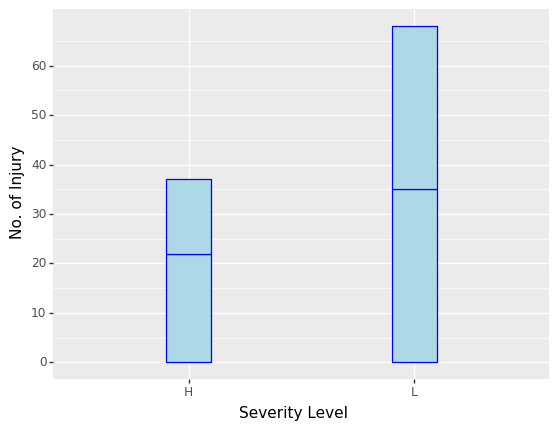

<ggplot: (184188205873)>

In [372]:
p2

In [133]:
# 2, injury count by body part, severity, surface 
# -- analyse by body part: ankle shows more severe injury on synthetic surface, knee and toes injury do not show significant difference on both surfaces
# -- surprisingly, foot has more severe injury reported on natural surface  
sevBodyPart = injury.groupBy('BodyPart', 'Severity','Surface').count().orderBy(col('BodyPart').asc(), col('Severity').desc(),col('Surface').asc())

In [134]:
sevBodyPart.show()

+--------+--------+---------+-----+
|BodyPart|Severity|  Surface|count|
+--------+--------+---------+-----+
|   Ankle|       4|  Natural|    3|
|   Ankle|       4|Synthetic|    8|
|   Ankle|       3|Synthetic|    2|
|   Ankle|       2|  Natural|    6|
|   Ankle|       2|Synthetic|    7|
|   Ankle|       1|  Natural|    8|
|   Ankle|       1|Synthetic|    8|
|    Foot|       4|  Natural|    4|
|    Foot|       4|Synthetic|    1|
|    Foot|       3|  Natural|    1|
|    Foot|       3|Synthetic|    1|
|    Heel|       2|  Natural|    1|
|    Knee|       4|  Natural|    6|
|    Knee|       4|Synthetic|    7|
|    Knee|       3|  Natural|    1|
|    Knee|       3|Synthetic|    2|
|    Knee|       2|  Natural|   12|
|    Knee|       2|Synthetic|    9|
|    Knee|       1|  Natural|    5|
|    Knee|       1|Synthetic|    6|
+--------+--------+---------+-----+
only showing top 20 rows



In [373]:
p3 = ggplot(sevBodyPart.toPandas(), aes(x='Severity', y="count", color="BodyPart", fill="BodyPart")) + \
    geom_bar(stat="identity", width=0.5) + \
    facet_grid('Surface ~ BodyPart') + \
    labs(x="Severity", y='No. of Injury') + \
    scale_y_continuous(breaks=np.arange(0, 12, 2))

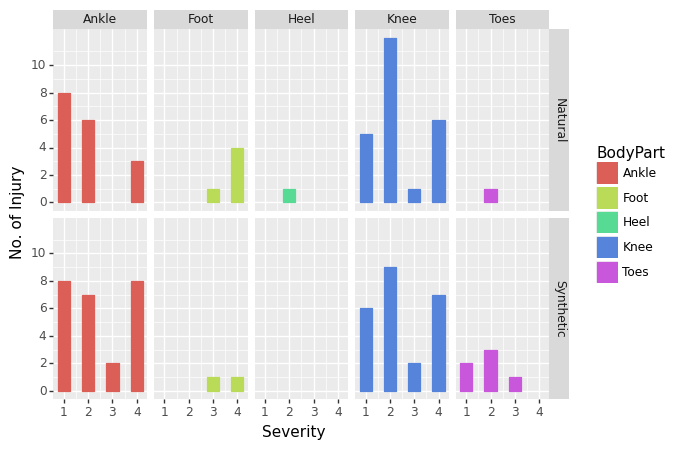

<ggplot: (184187888138)>

In [374]:
p3

In [328]:
# 3, injury count by roster position, severity, surface 
# -- the percentage of record without roster position is significant in this dataset, the data are too scattered
# -- no observation can be made
#detail = injury.join(playlist, injury.PlayKey == playlist.PlayKey, 'left')
detail = injury.join(playlist, injury.PlayKey == playlist.PlayKey)
#sevRosterPos = detail.groupBy('Surface','Severity','RosterPosition').count().orderBy(col('Severity').asc(), col('RosterPosition').asc())
sevRosterPos = detail.groupBy('Surface','RosterPosition','Severity').count().orderBy(col('RosterPosition').asc(), col('Severity').desc())

In [375]:
p4 = ggplot(sevRosterPos.toPandas(), aes(x='Severity', y="count",color='RosterPosition',fill='RosterPosition')) + \
    geom_bar(stat="identity", width=0.8, position='dodge') + \
    facet_grid('Surface ~ ') + \
    labs(x="Severity", y='No. of Injury')

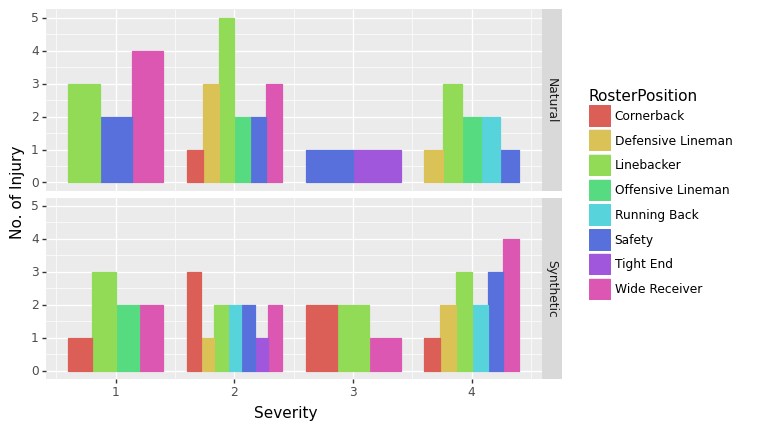

<ggplot: (184185807544)>

In [376]:
p4

In [377]:
pY = ggplot(sevRosterPos.toPandas(), aes(x='RosterPosition', y="count",color='Severity',fill='Severity')) + \
    geom_col(stat="identity", width=0.8) + \
    facet_grid('Surface ~ ') + \
    labs(x="RosterPosition", y='No. of Injury') + theme(axis_text_x = element_text(angle = 270, hjust = 1)) + \
    scale_y_continuous(breaks=np.arange(0, 12, 2))

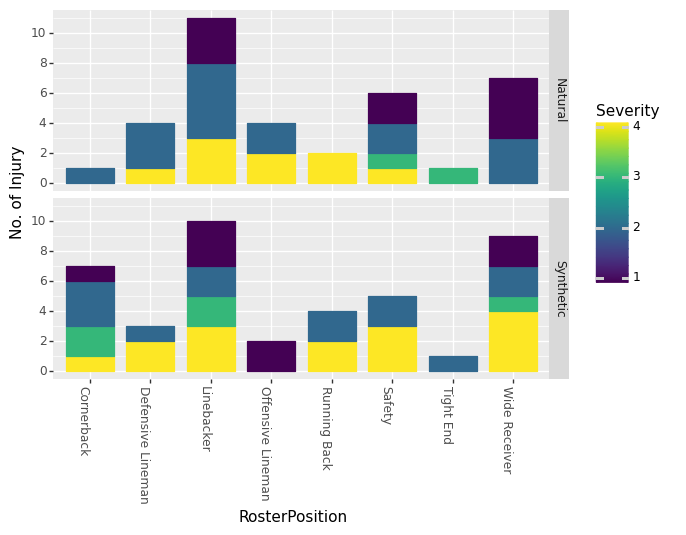

<ggplot: (184185805300)>

In [378]:
pY

In [265]:
sevRosterPos.show(100)

+---------+--------+-----------------+-----+
|  Surface|Severity|   RosterPosition|count|
+---------+--------+-----------------+-----+
|Synthetic|       1|       Cornerback|    1|
|  Natural|       1|       Linebacker|    3|
|Synthetic|       1|       Linebacker|    3|
|Synthetic|       1|Offensive Lineman|    2|
|  Natural|       1|           Safety|    2|
|Synthetic|       1|    Wide Receiver|    2|
|  Natural|       1|    Wide Receiver|    4|
|Synthetic|       2|       Cornerback|    3|
|  Natural|       2|       Cornerback|    1|
|Synthetic|       2|Defensive Lineman|    1|
|  Natural|       2|Defensive Lineman|    3|
|  Natural|       2|       Linebacker|    5|
|Synthetic|       2|       Linebacker|    2|
|  Natural|       2|Offensive Lineman|    2|
|Synthetic|       2|     Running Back|    2|
|  Natural|       2|           Safety|    2|
|Synthetic|       2|           Safety|    2|
|Synthetic|       2|        Tight End|    1|
|Synthetic|       2|    Wide Receiver|    2|
|  Natural

In [388]:
detail.select("Surface","Severity","SevLevel", "Weather", "StadiumType" , "FieldType").show()
injWeather = detail.groupBy('Surface','StadiumType','Weather').count().orderBy(col('Surface').asc(), col('StadiumType').asc(), col('Weather').asc())

+---------+--------+--------+------------------+-----------------+---------+
|  Surface|Severity|SevLevel|           Weather|      StadiumType|FieldType|
+---------+--------+--------+------------------+-----------------+---------+
|  Natural|       4|       H|             Sunny|          Outdoor|  Natural|
|  Natural|       3|       H|     Partly Cloudy|         Outdoors|  Natural|
|  Natural|       3|       H|     Partly Cloudy|          Outdoor|  Natural|
|  Natural|       2|       L|     Partly Cloudy|           Oudoor|  Natural|
|  Natural|       2|       L|             Clear|          Outdoor|  Natural|
|Synthetic|       2|       L|Controlled Climate|          Indoors|Synthetic|
|Synthetic|       4|       H|    Clear and warm|          Outdoor|Synthetic|
|  Natural|       2|       L|              Rain|          Outdoor|  Natural|
|Synthetic|       4|       H|       Clear skies|           Indoor|Synthetic|
|  Natural|       4|       H|              null|             Dome|  Natural|

In [402]:
injWeather.select('Weather').distinct().show(100)

+--------------------+
|             Weather|
+--------------------+
|         Rain shower|
|              Cloudy|
|      Clear and warm|
|                Cold|
|        Mostly sunny|
|              Indoor|
|     Cloudy and Cool|
|                null|
|             Indoors|
|Cloudy with perio...|
|               Coudy|
|         Clear skies|
|       Partly Cloudy|
|               Clear|
|               Sunny|
|                Fair|
|         Clear Skies|
|       Mostly cloudy|
|          Light Rain|
|  Controlled Climate|
|        Mostly Sunny|
|                Rain|
|Cloudy, 50% chang...|
|        Sun & clouds|
+--------------------+



In [403]:
playlist.select('Weather').distinct().show(100)

+--------------------+
|             Weather|
+--------------------+
|     Clear and sunny|
|      Clear and Cool|
|         Rain shower|
|      Sunny and cold|
|        Cloudy, Rain|
|  Mostly Sunny Skies|
|      Partly Clouidy|
|     Cloudy and cold|
|Cloudy, chance of...|
|              Cloudy|
|      Clear and warm|
|Sunny, highs to u...|
|                Cold|
|  10% Chance of Rain|
|        Mostly sunny|
|              Indoor|
|     Cloudy and Cool|
|                null|
|             Indoors|
|     Sunny and clear|
|Cloudy with perio...|
|      Clear and cold|
|               Coudy|
|Rain likely, temp...|
|         Clear skies|
|               Clear|
|       Partly Cloudy|
|        Partly clear|
|Clear to Partly C...|
|        Party Cloudy|
|       Partly cloudy|
|       N/A (Indoors)|
|               Sunny|
|      Sunny and warm|
|                Fair|
|       Mostly Cloudy|
|          N/A Indoor|
|               Rainy|
|         Clear Skies|
|Cloudy, fog start...|
|        Pa

In [ ]:
array_outdoors = ['Outdoor', 'Oudoor', 'Outdoors',
       'Ourdoor', 'Outddors', 'Heinz Field', 'Outdor', 'Outside', 'Cloudy']
array_indoors = ['Indoors', 'Indoor', 'Indoor', 'Retractable Roof']
array_open = ['Open','Outdoor Retr Roof-Open', 'Retr. Roof-Open', 'Indoor, Open Roof',
       'Domed, Open', 'Domed, open', 'Retr. Roof - Open']
array_closed = ['Closed Dome', 'Domed, closed', 'Dome', 'Domed',
       'Retr. Roof-Closed', 'Outdoor Retr Roof-Open', 'Retractable Roof', 'Indoor, Roof Closed', 'Retr. Roof - Closed', 'Bowl', 'Dome, closed',
       'Retr. Roof Closed']

PlayList['StadiumType'] = PlayList['StadiumType'].replace(array_outdoors, 'Outdoors')
PlayList['StadiumType'] = PlayList['StadiumType'].replace(array_indoors, 'Indoors')
PlayList['StadiumType'] = PlayList['StadiumType'].replace(array_open, 'Open')
PlayList['StadiumType'] = PlayList['StadiumType'].replace(array_closed, 'Closed')

In [ ]:
#spark.stop()